In [1]:
import pandas as pd
import logging
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:

df = pd.read_csv('/kaggle/input/breakhis/Folds.csv')
df1 = df[df["fold"] == 1].copy()  # Use copy to avoid modifying the original DataFrame
df1.rename(columns={"filename": "path"}, inplace=True)

for index, row in df1.iterrows():
    df1.loc[index, "filename"] = row["path"].split('/')[8]
    df1.loc[index, "class"] = row["path"].split('/')[3]
    df1.loc[index, "slide_id"] = row["path"].split('/')[8].split("-")[2]
    df1.loc[index, "tumor_type"] = row["path"].split('/')[8].split("-")[0].split("_")[2]

print(df1.head())

   fold  mag    grp                                               path  \
0     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
1     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
2     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
3     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
4     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   

                         filename   class slide_id tumor_type  
0  SOB_B_A-14-22549AB-100-001.png  benign  22549AB          A  
1  SOB_B_A-14-22549AB-100-002.png  benign  22549AB          A  
2  SOB_B_A-14-22549AB-100-003.png  benign  22549AB          A  
3  SOB_B_A-14-22549AB-100-004.png  benign  22549AB          A  
4  SOB_B_A-14-22549AB-100-005.png  benign  22549AB          A  


In [3]:
# Supondo que df seja o seu DataFrame
df_grouped = df1.groupby(['slide_id', 'mag'])['filename'].count().reset_index()

# Renomear a coluna de contagem para 'filename_count'
df_grouped.rename(columns={'filename': 'filename_count'}, inplace=True)
df_grouped.to_csv('df_grouped.csv', index=False)

print(df_grouped)

    slide_id  mag  filename_count
0      10147   40              15
1      10147  100              12
2      10147  200              22
3      10147  400              15
4      10926   40              11
..       ...  ...             ...
319     9146  400              24
320     9461   40              26
321     9461  100              36
322     9461  200              62
323     9461  400              31

[324 rows x 3 columns]


# DATASET

The dataset consists of 7,909 microscopic images of breast tumour tissue collected from **82 patients** at various magnification factors.

* Benign:
    * Adenosis (A)
    * Fibroadenoma (F)
    * Phyllodes tumour (PT)
    * Tubular adenoma (TA)
* Malignant:
    * Carcinoma (DC)
    * Lobular carcinoma (LC)
    * Mucinous carcinoma (MC)
    * Papillary carcinoma (PC)
    

# Análise estatística do conjunto

In [4]:
print("")
print(f"Quantidade total de imagens: {len(df1)}")
print("")

print("Quantidade de paciente por tipo de tumor")
slide_id_counts = df1.groupby('tumor_type')['slide_id'].nunique()
total_count = slide_id_counts.sum()
slide_id_counts['Total'] = total_count
print(slide_id_counts)

# Filtrar por classe 'benign'
df_class_b = df1[df1['class'] == 'benign']
# Filtrar por classe 'malignant'
df_class_m = df1[df1['class'] == 'malignant']

# Calcular o somatório do total de imagens para cada valor de magnificação para benign e malignant
total_images_per_mag_b = df_class_b.groupby('mag').size()
total_images_per_mag_m = df_class_m.groupby('mag').size().tolist()
print(total_images_per_mag_b)
data = {
    'Total_Images_Benign': total_images_per_mag_b,
    'Total_Images_Malignant': total_images_per_mag_m,
    'Total_Images': df1.groupby('mag').size().tolist()
}

total_images_df = pd.DataFrame(data)

# Add a row representing the total sum for each column
total_images_df.loc['Total'] = total_images_df.sum()

print(total_images_df)



Quantidade total de imagens: 7909

Quantidade de paciente por tipo de tumor
tumor_type
A         4
DC       38
F        10
LC        5
MC        9
PC        6
PT        3
TA        7
Total    82
Name: slide_id, dtype: int64
mag
40     625
100    644
200    623
400    588
dtype: int64
       Total_Images_Benign  Total_Images_Malignant  Total_Images
mag                                                             
40                     625                    1370          1995
100                    644                    1437          2081
200                    623                    1390          2013
400                    588                    1232          1820
Total                 2480                    5429          7909


In [5]:
print("")
print(f"Quantidade total de imagens: ", len(df1))
print("")

slide_id_counts = df1.groupby('tumor_type')['slide_id'].nunique()
# Add a total row
total_count = slide_id_counts.sum()
slide_id_counts['Total'] = total_count

print(slide_id_counts)

df_class_b = df1[df1['class'] == 'benign']
df_class_m = df1[df1['class'] == 'malignant']

data = {
    'Magnification': df1['mag'].unique(),
    #Para cada valor de mag, o somatório do total de imagens que pertencer a class benign
    #Para cada valor de mag, o somatório do total de imagens que pertencer a class malignant
    'Total_Images': df1.groupby('mag').size().tolist()
}
# Create DataFrame
total_images_df = pd.DataFrame(data)

print(total_images_df)



Quantidade total de imagens:  7909

tumor_type
A         4
DC       38
F        10
LC        5
MC        9
PC        6
PT        3
TA        7
Total    82
Name: slide_id, dtype: int64
   Magnification  Total_Images
0            100          1995
1            200          2081
2             40          2013
3            400          1820


In [6]:
def annotations(ax, total=None):
    # Show number in each bar
    if total is None:
        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=10, color='black', xytext=(0, -10),
                        textcoords='offset points')
    # Show number and percentage in each bar
    else:
        for p in ax.patches:
            count = int(p.get_height())
            percentage = (count / total) * 100
            ax.annotate(f'{count}\n({percentage:.1f}%)', 
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=10, color='black', xytext=(0, -15),
                        textcoords='offset points')
    return ax

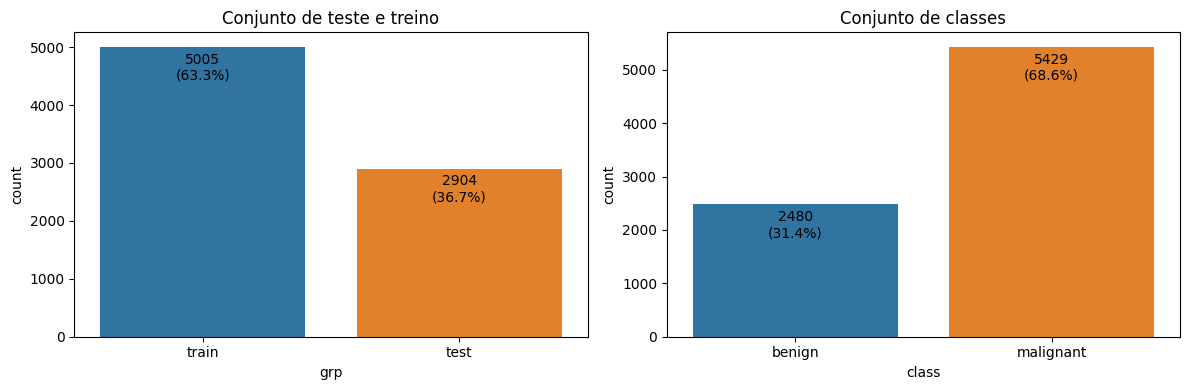

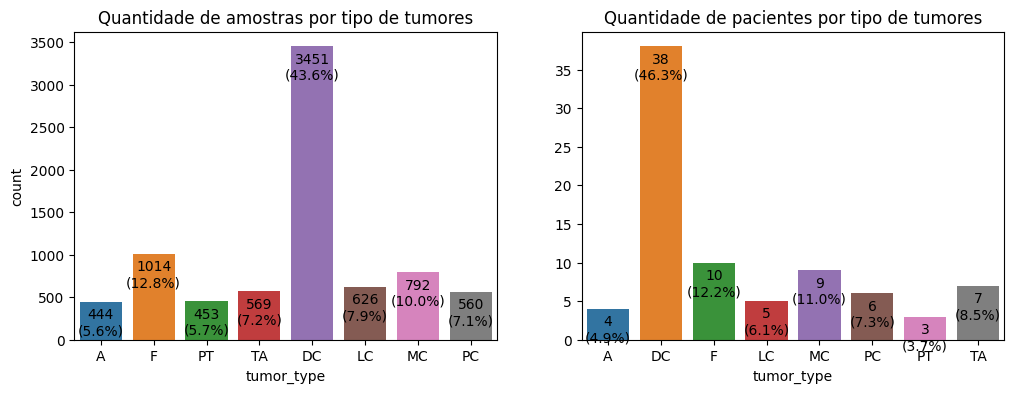

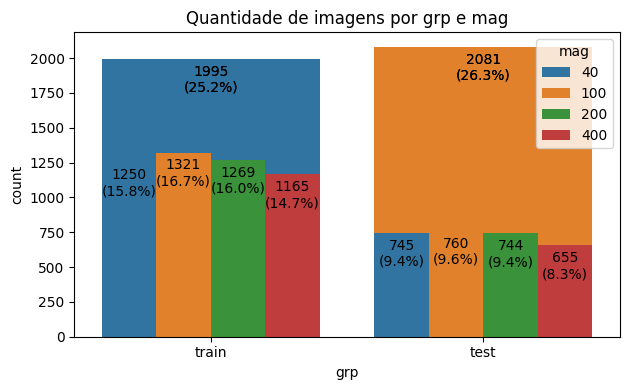

In [7]:

# Plot 1
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
ax1 = sns.countplot(x='grp', data=df1)
plt.title('Conjunto de teste e treino')
annotations(ax1, len(df1))

# Plot 2
plt.subplot(1, 2, 2)
ax2 = sns.countplot(x='class', data=df1)
plt.title('Conjunto de classes')
annotations(ax2, len(df1))

plt.tight_layout()
plt.show()

# Plot 3
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
ax3 = sns.countplot(x='tumor_type', data=df1)
plt.title('Quantidade de amostras por tipo de tumores')
annotations(ax3, len(df1) )

# Plot 4
plt.subplot(1, 2, 2)
slide_id_counts = df1.groupby('tumor_type')['slide_id'].nunique()
ax4 = sns.barplot(x=slide_id_counts.index, y=slide_id_counts.values)
plt.title('Quantidade de pacientes por tipo de tumores')
annotations(ax4, slide_id_counts.sum())

# Plot 5
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
ax5 = sns.countplot(x='mag', data=df1)
plt.title('Quantidade de imagens por mag')
annotations(ax5, len(df1))

# Plot 6
ax6 = sns.countplot(x='grp', hue='mag', data=df1)
plt.title('Quantidade de imagens por grp e mag')
annotations(ax6, len(df1))


plt.tight_layout()
plt.show()

* Quantidade de imagens por pasta

In [8]:
import os
import shutil
shutil.copy('/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/count_files.sh', '/kaggle/working/count_files.sh')
os.system('bash /kaggle/working/count_files.sh /kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/')

/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X : 16
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/400X : 17
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/40X : 15
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/100X : 13
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/200X : 31
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/400X : 30
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/40X : 35
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/100X : 36
/kaggle/input/breakhis/BreaKHis_v1/BreaKHi

0

* Amostras por cada tipo de tumor

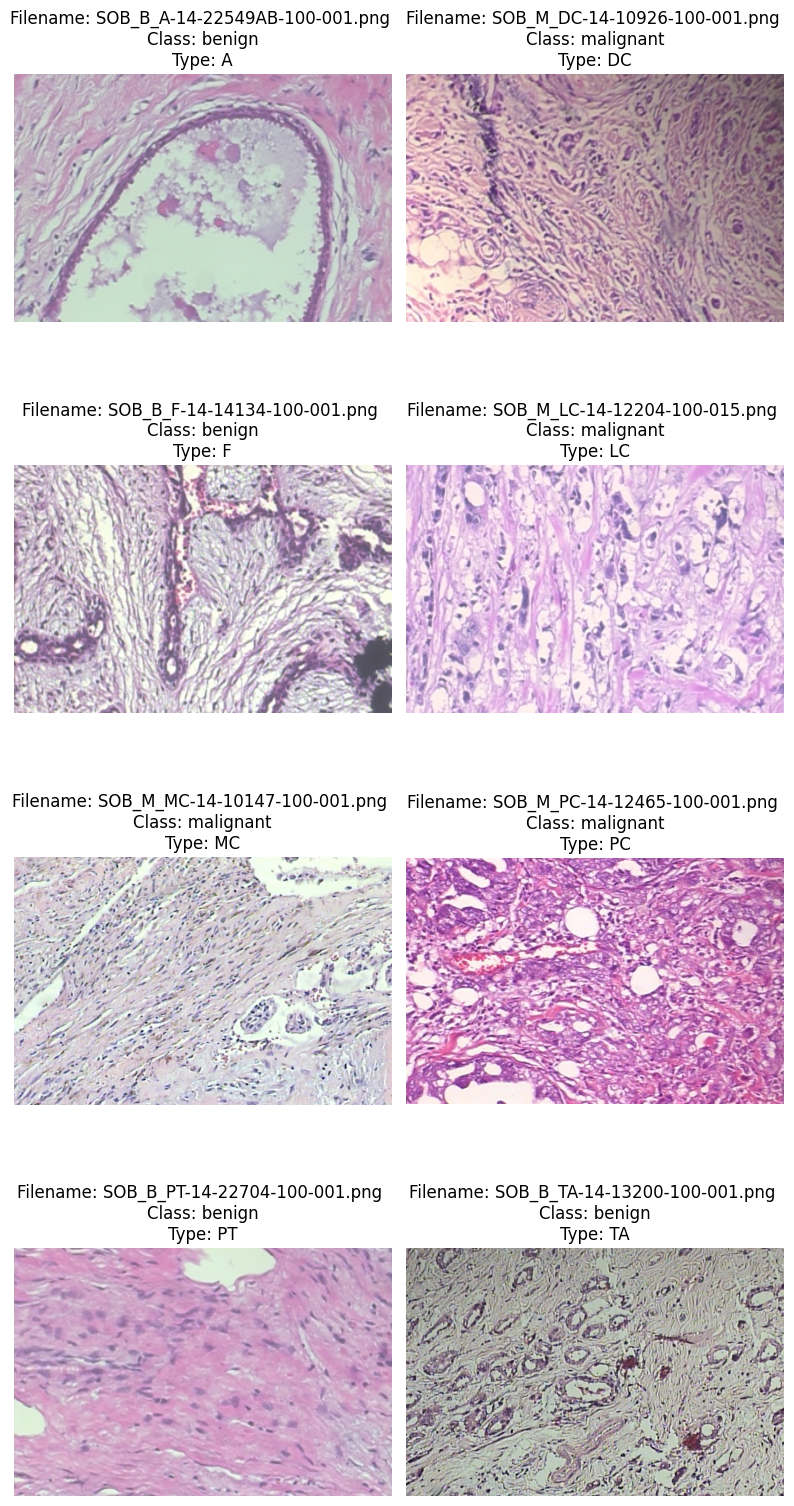

None

In [9]:
# Assuming df1 is your DataFrame
grouped_df1 = df1.groupby('tumor_type').first()

# Set the desired width and height
image_width = 4
image_height = 4

# Number of images per row and column
num_images_per_row = 2
num_images_per_col = 4

# Create a grid layout
fig, axes = plt.subplots(num_images_per_col, num_images_per_row, figsize=(num_images_per_row * image_width, num_images_per_col * image_height))
fig.subplots_adjust(hspace=0.5)  # Adjust the vertical space between subplots

for (index, row), ax in zip(grouped_df1.iterrows(), axes.flatten()):
    
    img_path = "/kaggle/input/breakhis/BreaKHis_v1/" + row['path']
    
    # Load and display the image
    img = plt.imread(img_path)
    ax.imshow(img)
    ax.set_title(f"Filename: {row['filename']} \nClass: {row['class']}\nType: {index}")
    ax.axis('off')  # Turn off axis labels
    
# Adjust layout
plt.tight_layout()

# Display the plot
display(plt.show())